In [1]:
import numpy as np
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
import pandas as pd
from nltk.corpus import stopwords
import re
import json
STOPWORDS = set(stopwords.words('english'))
import os

In [2]:
embedding_dim=100
oov_token = '<OOV>'
train_test_split = 0.8
max_len = 200
trunc_type = 'post'
padding_type = 'post'

In [3]:
df = pd.read_csv('../bbc-text.csv')
labels = df.get('category').values.tolist()
articles = df.get('text').values.tolist()
for i in range(len(articles)):
    for word in STOPWORDS:
        token = ' '+word+' '
        articles[i] = articles[i].replace(token,' ')
        articles[i] = re.sub(r'\s+', ' ',articles[i])

In [4]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(articles)
sequences = tokenizer.texts_to_sequences(articles)
article_sequences = pad_sequences(sequences,maxlen=max_len,truncating=trunc_type,padding=padding_type)
word_index = tokenizer.word_index
vocab_size = len(word_index)

split_index = int(len(article_sequences)*train_test_split)
train_sequences = np.array(article_sequences[0:split_index])
test_sequences = np.array(article_sequences[split_index:])

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_sequences = label_tokenizer.texts_to_sequences(labels)
train_label = np.array(label_sequences[0:split_index])
test_label = np.array(label_sequences[split_index:])

In [5]:
tokenizer_json = tokenizer.to_json()
label_tokenizer_json = label_tokenizer.to_json()

In [7]:
embeddings_index = {};
with open('../../glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [8]:
if not os.path.exists('tokenizer.json'):
    with open('tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
if not os.path.exists('label_tokenizer_json.json'):
    with open('label_tokenizer_json.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(label_tokenizer_json, ensure_ascii=False))

In [9]:
np.save('train_sequences.npy',train_sequences)
np.save('train_label.npy',train_label)
np.save('test_sequences.npy',test_sequences)
np.save('test_label.npy',test_label)
np.save('embeddings_matrix.npy',embeddings_matrix)

In [10]:
print(train_sequences.shape)
print(train_label.shape)
print(test_sequences.shape)
print(test_label.shape)
print(vocab_size)
print(word_index['i'])

(1780, 200)
(1780, 1)
(445, 200)
(445, 1)
29699
4814


In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, LSTM, Embedding,Conv2D,Bidirectional,MaxPool2D,Reshape
from keras.models import load_model
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
from keras.callbacks import ModelCheckpoint
import json
import os
import datetime as dt
from matplotlib import pyplot as plt

In [12]:
with open('tokenizer.json', 'r', encoding='utf-8') as f1:
    tokenizer_config = json.load(f1)
with open('label_tokenizer_json.json', 'r', encoding='utf-8') as f2:
    label_tokenizer_config = json.load(f2)

In [13]:
train_sequences= np.load('train_sequences.npy')
train_label= np.load('train_label.npy')
test_sequences = np.load('test_sequences.npy')
test_label= np.load('test_label.npy')
embeddings_matrix= np.load('embeddings_matrix.npy')

In [14]:
tokenizer = tokenizer_from_json(tokenizer_config)
label_tokenizer = tokenizer_from_json(label_tokenizer_config)

In [15]:
embedding_dim = 100
word_index = word_index
vocab_size = vocab_size
max_len = 200
rnn_units = 100

In [16]:
model = Sequential()
model.add(Embedding(vocab_size+1,embedding_dim,input_length=max_len,weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(rnn_units,return_sequences=True),merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Reshape((-1,rnn_units,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          2970000   
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 100)         160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200, 100)          0         
                                                                 
 reshape (Reshape)           (None, 200, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 98, 64)       640       
                                                        

In [17]:
epochs = 10
save_dir = './saved_model'
save_fname = os.path.join(save_dir, "情感2.h5")
callbacks = [ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 20s 318ms/step - loss: 1.7188 - accuracy: 0.2388 - val_loss: 1.6743 - val_accuracy: 0.3438
Epoch 2/10
56/56 [==============================] - 18s 317ms/step - loss: 1.6318 - accuracy: 0.3197 - val_loss: 1.6133 - val_accuracy: 0.3820
Epoch 3/10
56/56 [==============================] - 18s 317ms/step - loss: 1.5767 - accuracy: 0.3747 - val_loss: 1.5711 - val_accuracy: 0.4360
Epoch 4/10
56/56 [==============================] - 20s 351ms/step - loss: 1.5417 - accuracy: 0.3854 - val_loss: 1.5350 - val_accuracy: 0.5461
Epoch 5/10
56/56 [==============================] - 25s 443ms/step - loss: 1.5114 - accuracy: 0.4472 - val_loss: 1.5040 - val_accuracy: 0.5775
Epoch 6/10
56/56 [==============================] - 25s 439ms/step - loss: 1.4786 - accuracy: 0.4865 - val_loss: 1.4764 - val_accuracy: 0.6427
Epoch 7/10
56/56 [==============================] - 25s 438ms/step - loss: 1.4554 - accuracy: 0.5270 - val_loss: 1.4506 - val_accuracy: 0.6337

In [ ]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 69s 286ms/step - loss: 0.6943 - accuracy: 0.5393 - val_loss: 0.6979 - val_accuracy: 0.6271
Epoch 2/10
241/241 [==============================] - 70s 290ms/step - loss: 0.6932 - accuracy: 0.5473 - val_loss: 0.6963 - val_accuracy: 0.5257
Epoch 3/10
241/241 [==============================] - 71s 296ms/step - loss: 0.6918 - accuracy: 0.5389 - val_loss: 0.6945 - val_accuracy: 0.5767
Epoch 4/10
241/241 [==============================] - 69s 287ms/step - loss: 0.6911 - accuracy: 0.5407 - val_loss: 0.6929 - val_accuracy: 0.6100
Epoch 5/10
 75/241 [========>.....................] - ETA: 47s - loss: 0.6900 - accuracy: 0.5417

In [18]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 32s 576ms/step - loss: 1.3710 - accuracy: 0.6146 - val_loss: 1.3588 - val_accuracy: 0.7236
Epoch 2/10
56/56 [==============================] - 32s 578ms/step - loss: 1.3481 - accuracy: 0.6539 - val_loss: 1.3377 - val_accuracy: 0.7303
Epoch 3/10
56/56 [==============================] - 32s 570ms/step - loss: 1.3264 - accuracy: 0.6522 - val_loss: 1.3167 - val_accuracy: 0.7461
Epoch 4/10
56/56 [==============================] - 32s 568ms/step - loss: 1.3097 - accuracy: 0.6719 - val_loss: 1.2965 - val_accuracy: 0.7528
Epoch 5/10
56/56 [==============================] - 34s 614ms/step - loss: 1.2850 - accuracy: 0.7006 - val_loss: 1.2762 - val_accuracy: 0.7528
Epoch 6/10
56/56 [==============================] - 33s 591ms/step - loss: 1.2660 - accuracy: 0.7163 - val_loss: 1.2546 - val_accuracy: 0.7551
Epoch 7/10
56/56 [==============================] - 33s 582ms/step - loss: 1.2493 - accuracy: 0.7112 - val_loss: 1.2349 - val_accuracy: 0.7730

In [19]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 33s 592ms/step - loss: 1.1690 - accuracy: 0.7657 - val_loss: 1.1532 - val_accuracy: 0.8247
Epoch 2/10
56/56 [==============================] - 32s 573ms/step - loss: 1.1533 - accuracy: 0.7601 - val_loss: 1.1322 - val_accuracy: 0.8247
Epoch 3/10
56/56 [==============================] - 31s 559ms/step - loss: 1.1296 - accuracy: 0.7629 - val_loss: 1.1121 - val_accuracy: 0.8292
Epoch 4/10
56/56 [==============================] - 31s 558ms/step - loss: 1.1106 - accuracy: 0.7826 - val_loss: 1.0916 - val_accuracy: 0.8292
Epoch 5/10
56/56 [==============================] - 31s 557ms/step - loss: 1.0908 - accuracy: 0.7865 - val_loss: 1.0708 - val_accuracy: 0.8292
Epoch 6/10
56/56 [==============================] - 31s 558ms/step - loss: 1.0690 - accuracy: 0.7978 - val_loss: 1.0505 - val_accuracy: 0.8427
Epoch 7/10
56/56 [==============================] - 32s 569ms/step - loss: 1.0480 - accuracy: 0.8011 - val_loss: 1.0301 - val_accuracy: 0.8427

In [20]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 34s 605ms/step - loss: 0.9677 - accuracy: 0.8264 - val_loss: 0.9477 - val_accuracy: 0.8607
Epoch 2/10
56/56 [==============================] - 32s 572ms/step - loss: 0.9505 - accuracy: 0.8326 - val_loss: 0.9283 - val_accuracy: 0.8629
Epoch 3/10
56/56 [==============================] - 32s 569ms/step - loss: 0.9298 - accuracy: 0.8388 - val_loss: 0.9080 - val_accuracy: 0.8629
Epoch 4/10
56/56 [==============================] - 33s 594ms/step - loss: 0.9137 - accuracy: 0.8449 - val_loss: 0.8871 - val_accuracy: 0.8674
Epoch 5/10
56/56 [==============================] - 35s 630ms/step - loss: 0.8890 - accuracy: 0.8421 - val_loss: 0.8680 - val_accuracy: 0.8719
Epoch 6/10
56/56 [==============================] - 33s 580ms/step - loss: 0.8698 - accuracy: 0.8522 - val_loss: 0.8500 - val_accuracy: 0.8764
Epoch 7/10
56/56 [==============================] - 32s 565ms/step - loss: 0.8555 - accuracy: 0.8438 - val_loss: 0.8297 - val_accuracy: 0.8809

In [24]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 32s 575ms/step - loss: 0.7798 - accuracy: 0.8646 - val_loss: 0.7579 - val_accuracy: 0.8809
Epoch 2/10
56/56 [==============================] - 36s 641ms/step - loss: 0.7626 - accuracy: 0.8753 - val_loss: 0.7384 - val_accuracy: 0.8921
Epoch 3/10
56/56 [==============================] - 36s 637ms/step - loss: 0.7444 - accuracy: 0.8747 - val_loss: 0.7217 - val_accuracy: 0.8899
Epoch 4/10
56/56 [==============================] - 36s 636ms/step - loss: 0.7247 - accuracy: 0.8770 - val_loss: 0.7056 - val_accuracy: 0.8899
Epoch 5/10
56/56 [==============================] - 33s 597ms/step - loss: 0.7116 - accuracy: 0.8747 - val_loss: 0.6876 - val_accuracy: 0.8944
Epoch 6/10
56/56 [==============================] - 33s 596ms/step - loss: 0.6964 - accuracy: 0.8815 - val_loss: 0.6724 - val_accuracy: 0.8966
Epoch 7/10
56/56 [==============================] - 35s 624ms/step - loss: 0.6794 - accuracy: 0.8904 - val_loss: 0.6566 - val_accuracy: 0.8989

In [29]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 25s 440ms/step - loss: 0.6208 - accuracy: 0.8893 - val_loss: 0.5965 - val_accuracy: 0.9124
Epoch 2/10
56/56 [==============================] - 31s 559ms/step - loss: 0.6001 - accuracy: 0.8989 - val_loss: 0.5827 - val_accuracy: 0.9169
Epoch 3/10
56/56 [==============================] - 31s 560ms/step - loss: 0.5919 - accuracy: 0.8972 - val_loss: 0.5694 - val_accuracy: 0.9191
Epoch 4/10
56/56 [==============================] - 33s 584ms/step - loss: 0.5824 - accuracy: 0.8933 - val_loss: 0.5569 - val_accuracy: 0.9213
Epoch 5/10
56/56 [==============================] - 34s 605ms/step - loss: 0.5663 - accuracy: 0.9011 - val_loss: 0.5478 - val_accuracy: 0.9191
Epoch 6/10
56/56 [==============================] - 34s 617ms/step - loss: 0.5530 - accuracy: 0.9051 - val_loss: 0.5336 - val_accuracy: 0.9326
Epoch 7/10
56/56 [==============================] - 33s 597ms/step - loss: 0.5405 - accuracy: 0.9034 - val_loss: 0.5215 - val_accuracy: 0.9303

In [33]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
56/56 [==============================] - 36s 636ms/step - loss: 0.4922 - accuracy: 0.9140 - val_loss: 0.4782 - val_accuracy: 0.9348
Epoch 2/10
56/56 [==============================] - 34s 613ms/step - loss: 0.4833 - accuracy: 0.9140 - val_loss: 0.4695 - val_accuracy: 0.9326
Epoch 3/10
56/56 [==============================] - 35s 631ms/step - loss: 0.4781 - accuracy: 0.9129 - val_loss: 0.4591 - val_accuracy: 0.9326
Epoch 4/10
56/56 [==============================] - 35s 619ms/step - loss: 0.4630 - accuracy: 0.9236 - val_loss: 0.4490 - val_accuracy: 0.9371
Epoch 5/10
56/56 [==============================] - 36s 644ms/step - loss: 0.4544 - accuracy: 0.9152 - val_loss: 0.4406 - val_accuracy: 0.9416
Epoch 6/10
56/56 [==============================] - 34s 608ms/step - loss: 0.4449 - accuracy: 0.9140 - val_loss: 0.4333 - val_accuracy: 0.9348
Epoch 7/10
56/56 [==============================] - 35s 623ms/step - loss: 0.4340 - accuracy: 0.9197 - val_loss: 0.4239 - val_accuracy: 0.9393

In [34]:
import joblib
joblib.dump(model,"文本分类.pkl")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\conv2d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\embedding
......vars
.........0
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\reshape
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
......

['文本分类.pkl']

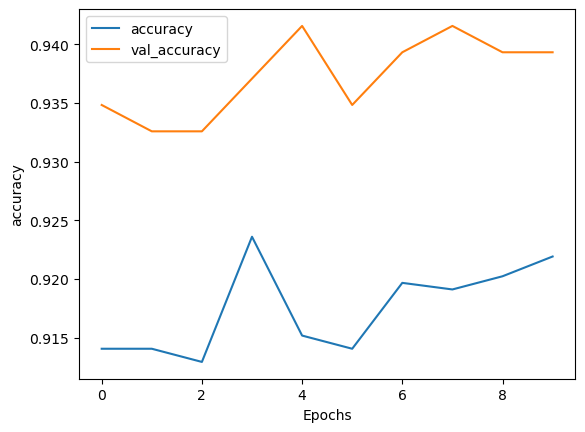

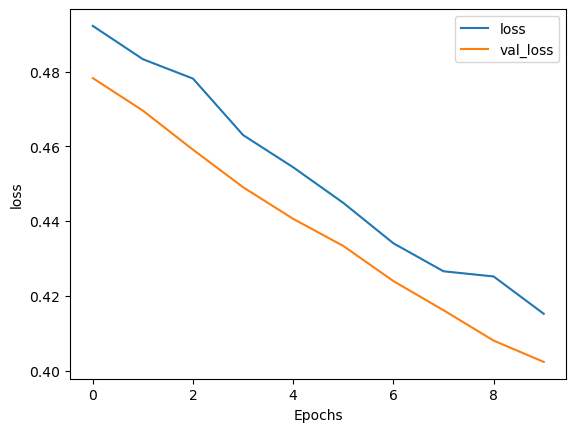

In [35]:
history = model.history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [36]:
joblib.dump(history,"history文本分类.pkl")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\conv2d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\embedding
......vars
.........0
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\reshape
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
......

['history文本分类.pkl']